<a href="https://colab.research.google.com/github/cacaomacao/CAN_for_navigation/blob/main/RingAttractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ring Attractor Network




## Tasks

1.   Visual Cue Based Goal
2.   Partial Visual Cue Based Goal
3.   Memorizing the Goal



In [ ]:
import numpy as np
import torch

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
plt.rcParams.update({'font.size': 22})

In [ ]:
from numpy.core.multiarray import ndarray
#@title Figure Funtions
#@markdown This cell contains several visualization functions

def plot_spike_tray(spike_data:np.ndarray, selected:np.ndarray):
  """
    Plot to see the spike tray of each neuron.

    Params:
      - Spike_Data (List[Int]): Matrix of the spikes (1) and empty data (0).
      - Selected (List[Int]): Information about expected neuron. Same structure
                              as spike data.
  """

  num_neurons = spike_data.shape[0]

  fig, ax = plt.subplots(figsize=(14, 6))

  ax.set_ylim(0, num_neurons)
  ax.set_xlim(0, spike_data.shape[1])

  for neuron in range(num_neurons):
    neuron_spike_times = np.where(spike_data[neuron] == 1)[0]

    ax.vlines(neuron_spike_times, neuron, neuron + 0.9, linewidth=0.5, color='black')

    track_indices = np.where(selected[neuron] == 1)[0]
    if len(track_indices) > 0:
        consecutive = np.split(track_indices, np.where(np.diff(track_indices) != 1)[0]+1)
        for con in consecutive:
            ax.hlines(neuron + 0.5, con[0], con[-1]+1, linewidth=2, color='red')

  ax.set_xlabel('Time')
  ax.set_ylabel('Neuron')
  # ax.set_title('Spike Plot')

  plt.show()

## Model

In [ ]:
#@title Brownian Thresholding
class BrownianThreshold:
  def __init__(self, N, base, tau = 0.1, alpha= 0.02):
    self._threshold = base * np.ones((N))

    self.alpha = alpha
    self.tau = tau
    self.base = base * np.ones((N))
    self.N = N

  def step(self):
    self._threshold += self.tau * (self.base - self._threshold) + self.alpha * np.random.rand(self.N)

  @property
  def threshold(self):
    return self._threshold

In [ ]:
class RingAttractor:
    """
        Model for the Ring attractor. Based on a LIF neural Network.
    """
    def __init__(self, N, threshold=1, tau= 0.1, WTA = False):
        """
        Params:
        - N (Int): Number of neurons
        - threshold (float): Threshold value to spike
        - tau (float): decaying factor for the network.
        - WTA (Bool): Whether to use WTA or not.
        """
        self.N = N

        self.v = np.zeros((N))
        self.spikes = np.zeros((N))

        self.weights = np.zeros((N, N))

        self.threshold = threshold
        self.tau = tau

        self.WTA = WTA

        self.simple_init()

    def simple_init(self):
        """ Default parameters for the ring network on the project. """
        self.init_local_connections([-0.4,-0.3,0.6,1,0.6,-0.3,-0.4])

    def reset(self):
        """ convert's all of numbers to zero """
        self.spikes = np.zeros_like(self)

    def init_local_connections(self, weight_conv):
        """
        Weight initialization process. Creates a diagonal-like matrix with the
        specified weight convolution for each row.
        """
        assert self.N >= len(weight_conv)

        for i, w in enumerate(weight_conv):
            for j in range(self.N):
                self.weights[(i+j-len(weight_conv)//2+self.N)%self.N,(j)%self.N] = w

    def step(self, input):
        """
        Step of the network.
        """

        self.v += -self.tau*self.v + input + self.weights @ self.spikes

        spike_mask = self.v > self.threshold

        if spike_mask.astype(float).sum()>0:
        # Spiking Dynamics

            if self.WTA:
                max_neuron_idx = np.random.choice(np.where(self.v == self.v.max())[0])
                spike_mask[:] = False
                spike_mask[max_neuron_idx] = True

                spike_maks_float = np.zeros_like(spike_mask)
                spike_maks_float[(max_neuron_idx-2+self.N)%self.N] -= 0.3
                spike_maks_float[(max_neuron_idx-1+self.N)%self.N] -= 0.5
                spike_maks_float[(max_neuron_idx+1+self.N)%self.N] -= 0.5
                spike_maks_float[(max_neuron_idx+2+self.N)%self.N] -= 0.3

                self.v += spike_maks_float

            self.v[spike_mask] = 0
        self.spikes = spike_mask.astype(float)

Creation of the Model

In [ ]:
ring = RingAttractor(9, WTA = True)

Weight filters

In [ ]:
ring.init_local_connections([-0.4,-0.3,0.6,1,0.6,-0.3,-0.4])

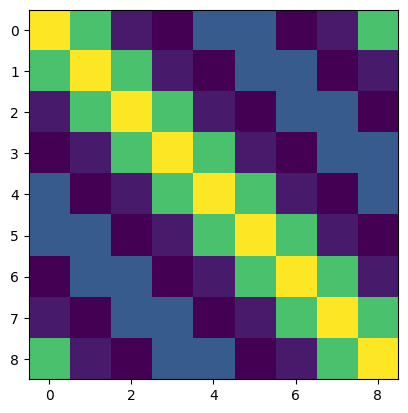

In [ ]:
plt.imshow(ring.weights)
plt.show()

## Demo 1: Slow movement

We will be using the ring network and feeding some input for 20 steps every 100 timesteps. The input will be in a neighboor neuron, so that we expect the attractor to follow the activity towards the activate neurons, representing how a fly attractor ring would follow the cues of the head.

After 15000 steps, no input will be fed, to assert that the network is stable and is in a neighboor of the real head position.

In [ ]:
ring = RingAttractor(9, WTA = True)

spikes = np.zeros((9, 10000))
v = np.zeros((9, 10000))
cur_pos = np.zeros((9, 10000))

act_pos = 0

for t in range(10000):
  input_val = np.zeros((9))

  if t%100 == 0 and t < 8000:
    act_pos = (act_pos + np.random.choice([-1, 1]) + 9)%9

  if t%100 < 20 and t < 8000:
    # Init
    input_val[act_pos] = 0.5


  ring.step(input_val)

  spikes[:, t] = ring.spikes
  v[:, t] = ring.v
  cur_pos[act_pos, t] = 1

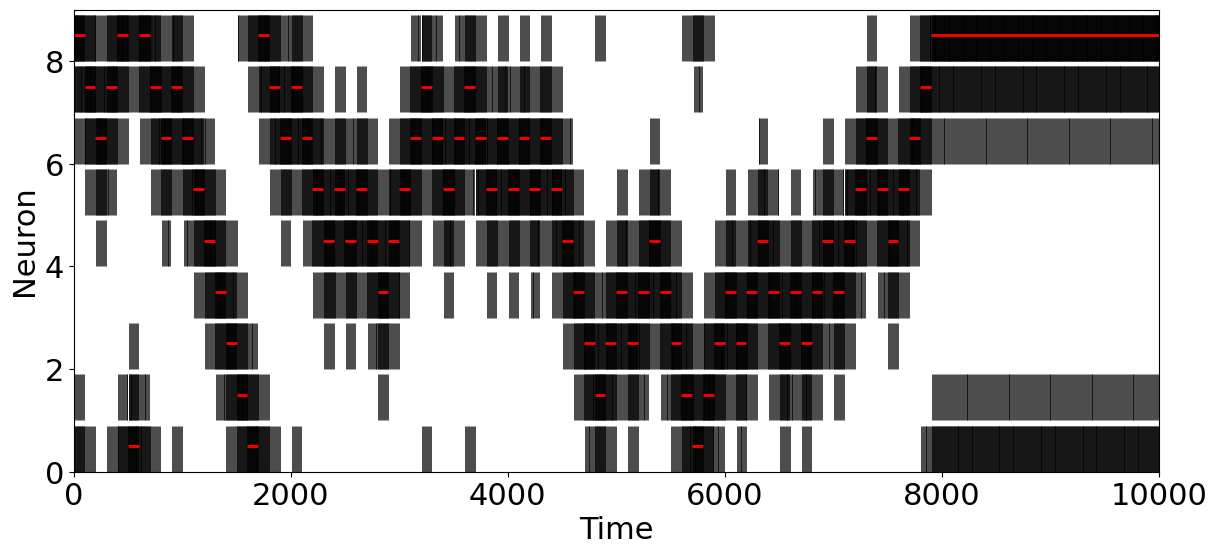

In [ ]:
plot_spike_tray(spikes, cur_pos)

## Demo 2: Fast movement

The head will start in a specific location and, on the timestep 1000, a fast movement will occur, so that input will be fed from the starting location to another in the antipode.

In [ ]:
ring = RingAttractor(9, WTA = True)

spikes = np.zeros((9, 600))
v = np.zeros((9, 600))
cur_pos = np.zeros((9, 600))

act_pos = 0

for t in range(600):
  input_val = np.zeros((9))

  if t==0:
    act_pos = (act_pos + np.random.choice([-1, 1]) + 9)%9
    print(f"Starting at {act_pos} | ending at {(act_pos+5)%9}")



  if t == 200:
    act_pos = (act_pos+1)%9
  elif t == 220:
    act_pos = (act_pos+1)%9
  elif t == 240:
    act_pos = (act_pos+1)%9
  elif t == 260:
    act_pos = (act_pos+1)%9
  elif t == 280:
    act_pos = (act_pos+1)%9

  if t < 20 or (t > 200 and t <300):
    # Init
    input_val[act_pos] = 0.5


  ring.step(input_val)

  spikes[:, t] = ring.spikes
  v[:, t] = ring.v
  cur_pos[act_pos, t] = 1

Starting at 1 | ending at 6


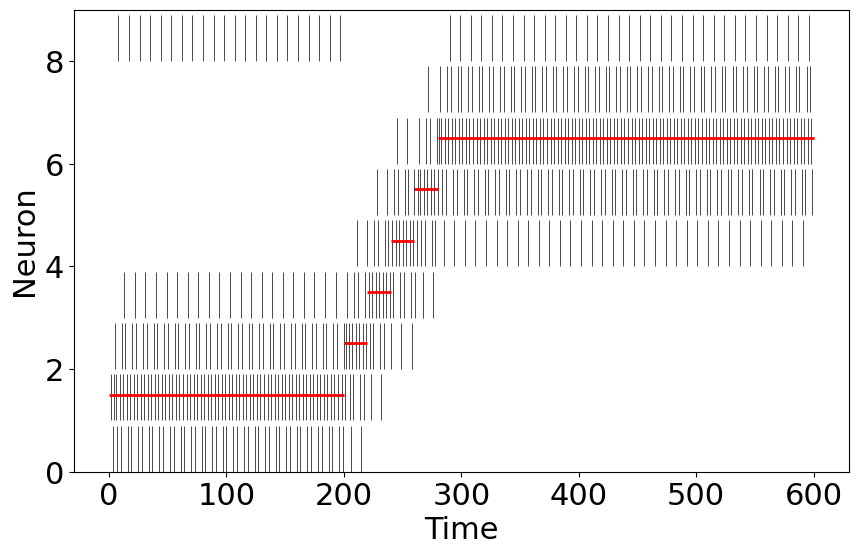

In [ ]:
plot_spike_tray(spikes, cur_pos)

## Demo 3: Confussing a Big Ring with two active locations

In this demo, we will analyze the behaviour of the ring in a case in which two locations are being used as input. The ring should not lean towards the second, as it is alredy being active on one of them.

In [ ]:
ring = RingAttractor(20, WTA = True)

spikes = np.zeros((20, 600))
v = np.zeros((20, 600))
cur_pos = np.zeros((20, 600))

act_pos = 0

for t in range(600):
  input_val = np.zeros((20))

  if t==0:
    act_pos = (act_pos + np.random.choice([-1, 1]) + 9)%9


  if t < 50:
    # Init
    input_val[act_pos] = 0.5

  if t > 300 and t < 400:
    # Init
    input_val[act_pos] = 0.5
    input_val[(act_pos+10)%20] = 0.5

  ring.step(input_val)

  spikes[:, t] = ring.spikes
  v[:, t] = ring.v
  cur_pos[act_pos, t] = 1

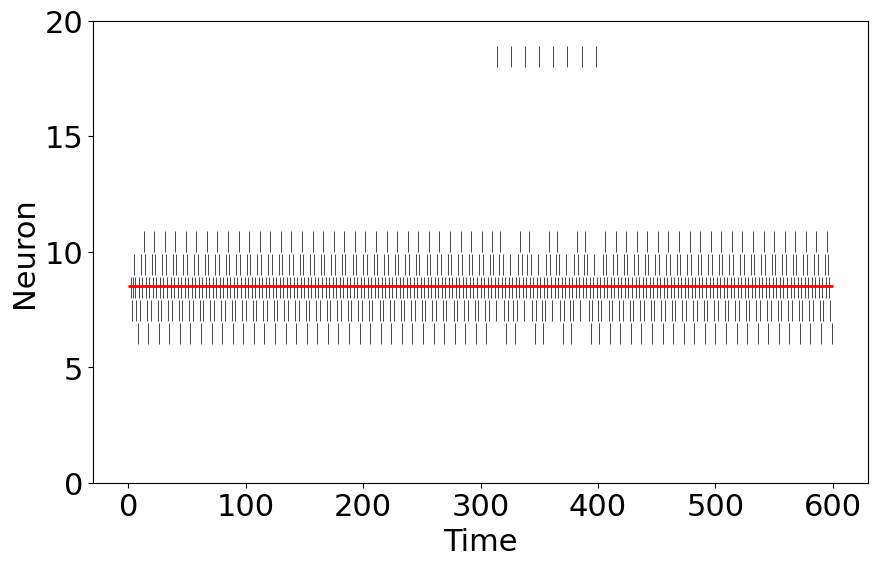

In [ ]:
plot_spike_tray(spikes, cur_pos)

## Demo 4: Instant Movement

In this demo, the bump jumps to a new location without a flow-like transition.

In [ ]:
ring = RingAttractor(20, WTA = True)

spikes = np.zeros((20, 600))
v = np.zeros((20, 600))
cur_pos = np.zeros((20, 600))

act_pos = 0

for t in range(600):
  input_val = np.zeros((20))

  if t==0:
    act_pos = (act_pos + np.random.choice([-1, 1]) + 9)%9+3


  if t < 100:
    # Init
    input_val[act_pos] = 0.5

  if t == 301:
    act_pos = (act_pos+10)%20
  if t > 300 and t < 400:
    # Init
    input_val[act_pos] = 0.5

  ring.step(input_val)

  spikes[:, t] = ring.spikes
  v[:, t] = ring.v
  cur_pos[act_pos, t] = 1

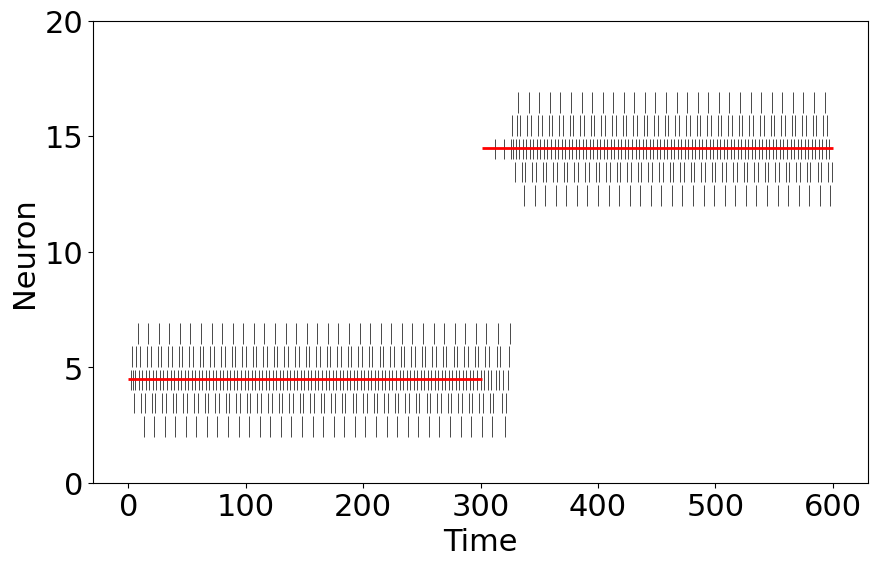

In [ ]:
plot_spike_tray(spikes, cur_pos)

# Bump Controlling Systems

## Left-Right Controller Ad-Hoc

In [ ]:
ring = RingAttractor(20, WTA = True)
ring.init_local_connections([-0.4,-0.3,0.6,1,0.6,-0.3,-0.4])

left_ring = RingAttractor(20, WTA = True)
left_ring.init_local_connections([-0.8,-0.6,-0.1,-0.05,-0.1,-0.6,-0.8])

ring_to_left = 0.2 * np.identity(20)

In [ ]:
left_to_ring = np.zeros_like(ring_to_left)
for j in range(20):
    left_to_ring[j][(j+1)%20] = 0.3
    left_to_ring[j][(j+2)%20] = 0.7
    left_to_ring[j][(j+3)%20] = 0.3

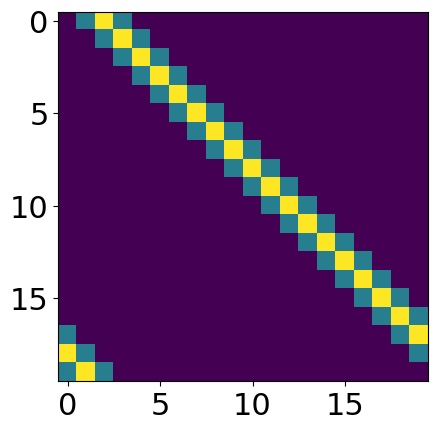

In [ ]:
plt.imshow(left_to_ring)

In [ ]:
steps = 2000
size = 20

spikes = np.zeros((size, steps))
v = np.zeros((size, steps))
cur_pos = np.zeros((size, steps))

spikes_left = np.zeros((size, steps))
v_left = np.zeros((size, steps))

act_pos = 0

for t in range(steps):
  input_val = np.zeros((size))

  if t==0:
    act_pos = (act_pos + np.random.choice([-1, 1]) + size)%size
    print(f"First position {act_pos}")


  if t < 50:
    input_val[act_pos] = 0.5


  ring.step(input_val + left_to_ring @ left_ring.spikes)

  if (t > 200 and t < 300) or (t > 1100 and t < 1500):
    left_ring.step(ring_to_left @ ring.spikes + 0.1)
  else:
    left_ring.step(ring_to_left @ ring.spikes)


  spikes[:, t] = ring.spikes
  v[:, t] = ring.v
  cur_pos[act_pos, t] = 1
  spikes_left[:, t] = left_ring.spikes
  v_left[:, t] = left_ring.v

First position 19


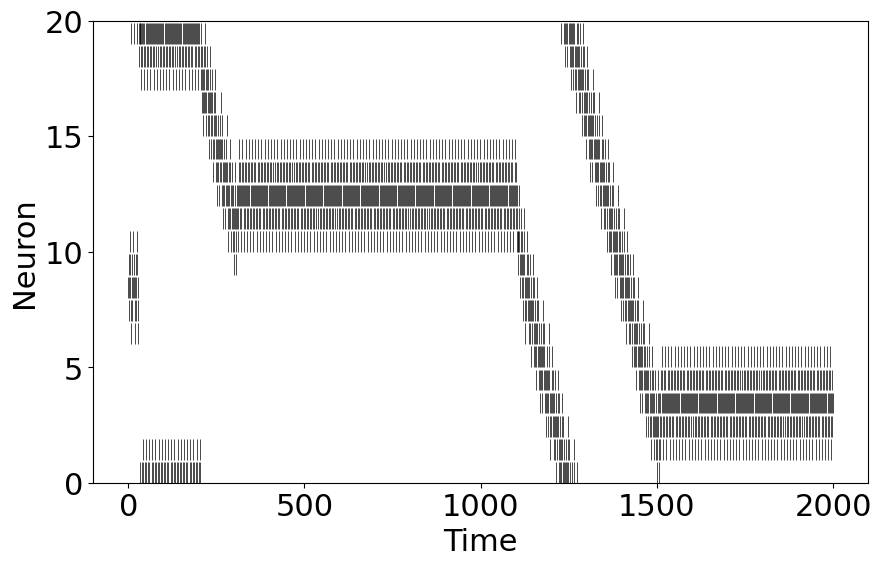

In [ ]:
plot_spike_tray(spikes, np.zeros_like(spikes))

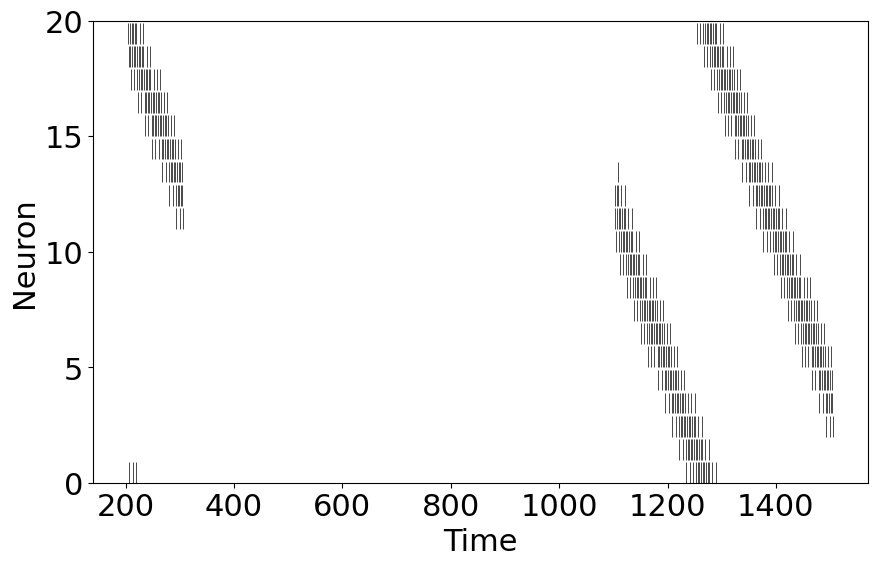

In [ ]:
plot_spike_tray(spikes_left, np.zeros_like(spikes))

### Abstract Controllable System

In [ ]:
class ControllableRing:

    def __init__(self, N):
        self.ring = RingAttractor(N, WTA = True)
        self.ring.init_local_connections([-0.4,-0.3,0.6,1,0.6,-0.3,-0.4])

        self.left_ring = RingAttractor(N, WTA = True)
        self.left_ring.init_local_connections([-0.8,-0.6,-0.1,-0.05,-0.1,-0.6,-0.8])

        self.ring_to_left = 0.2 * np.identity(N)
        self.left_to_ring = np.zeros_like(self.ring_to_left)
        for j in range(20):
            self.left_to_ring[j][(j+1)%20] = 0.3
            self.left_to_ring[j][(j+2)%20] = 0.7
            self.left_to_ring[j][(j+3)%20] = 0.3


        self.right_ring = RingAttractor(N, WTA = True)
        self.right_ring.init_local_connections([-0.8,-0.6,-0.1,-0.05,-0.1,-0.6,-0.8])

        self.ring_to_right = 0.2 * np.identity(N)
        self.right_to_ring = np.zeros_like(self.ring_to_right)
        for j in range(20):
            self.right_to_ring[j][(j-1+20)%20] = 0.3
            self.right_to_ring[j][(j-2+20)%20] = 0.7
            self.right_to_ring[j][(j-3+20)%20] = 0.3

    def step(self, input, left_current, right_current):
        self.ring.step(input_val + self.left_to_ring @ self.left_ring.spikes + self.right_to_ring @ self.right_ring.spikes )

        self.left_ring.step(self.ring_to_left @ self.ring.spikes + left_current)
        self.right_ring.step(self.ring_to_right @ self.ring.spikes + right_current)



In [ ]:
c_ring  = ControllableRing(20)

In [ ]:
steps = 2000
size = 20

spikes = np.zeros((size, steps))
v = np.zeros((size, steps))
cur_pos = np.zeros((size, steps))

spikes_left = np.zeros((size, steps))
v_left = np.zeros((size, steps))

spikes_right = np.zeros((size, steps))
v_right = np.zeros((size, steps))

act_pos = 0

for t in range(steps):
  input_val = np.zeros((size))

  if t==0:
    act_pos = 6


  if t < 50:
    input_val[act_pos] = 0.5

  if (t > 200 and t < 500):
    c_ring.step(input_val, 0.1, 0.0)
  elif (t > 1100 and t < 1500):
    c_ring.step(input_val, 0.0, 0.1)
  else:
    c_ring.step(input_val, 0.0, 0.0)


  spikes[:, t] = c_ring.ring.spikes
  v[:, t] = c_ring.ring.v
  cur_pos[act_pos, t] = 1
  spikes_left[:, t] = c_ring.left_ring.spikes
  v_left[:, t] = c_ring.left_ring.v
  spikes_right[:, t] = c_ring.right_ring.spikes
  v_right[:, t] = c_ring.right_ring.v

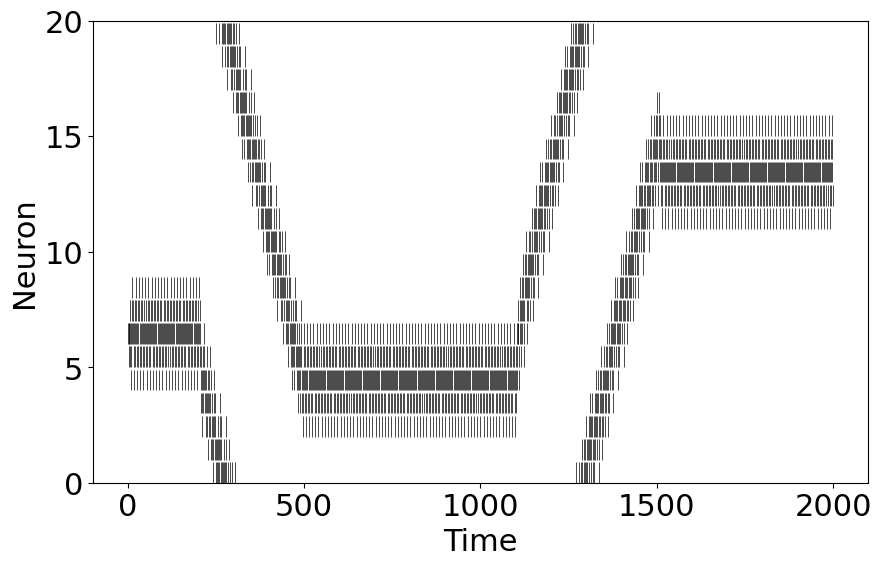

In [ ]:
plot_spike_tray(spikes, np.zeros_like(spikes))

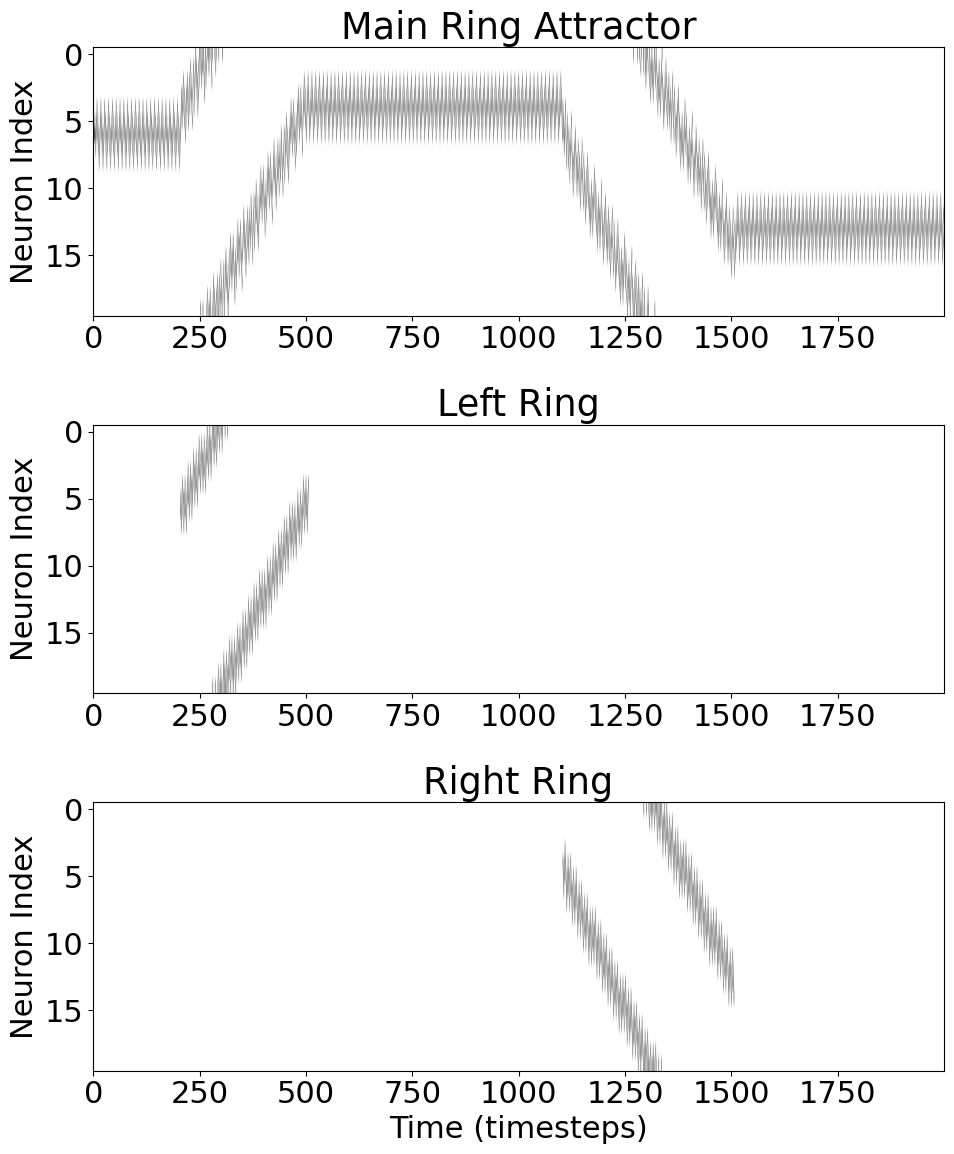

In [ ]:
# Plot the spike activity of the main ring attractor and left/right rings
plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
plt.imshow(spikes, cmap='gist_yarg', aspect='auto')
plt.title('Main Ring Attractor')
plt.ylabel('Neuron Index')

plt.subplot(3, 1, 2)
plt.imshow(spikes_left, cmap='gist_yarg', aspect='auto')
plt.title('Left Ring')
plt.ylabel('Neuron Index')

plt.subplot(3, 1, 3)
plt.imshow(spikes_right, cmap='gist_yarg', aspect='auto')
plt.title('Right Ring')
plt.xlabel('Time (timesteps)')
plt.ylabel('Neuron Index')

plt.tight_layout()
plt.show()

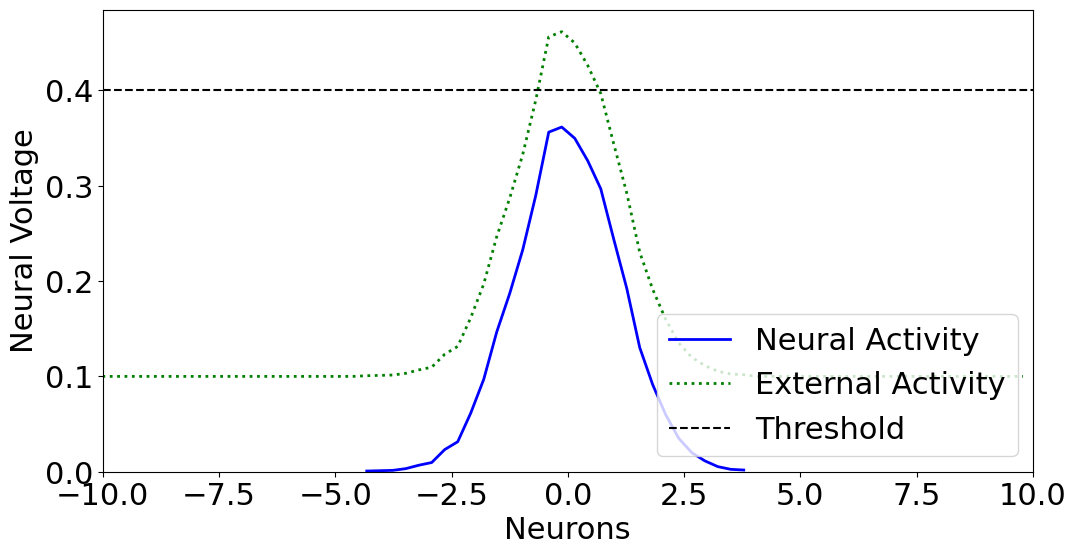

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Mean and standard deviation of the Gaussian distribution
mean = 0
std_dev = 0.5

# Number of data points to generate
num_points = 10000

# Generate data points from a Gaussian distribution
gaussian_data = np.random.normal(mean, std_dev, num_points)

# Standard deviation of the noise
noise_std_dev = 1

# Add noise to the data
noisy_data = gaussian_data + np.random.normal(0, noise_std_dev, num_points)

# Create a figure and axis
fig, ax = plt.subplots(figsize = (12,6))

# Plot the histogram of the noisy data as a line plot
hist, bins, _ = ax.hist(noisy_data, bins=30, density=True, alpha=0.0, color='blue')

# Set the histogram bins to the center of each bin for a smoother line plot
bin_centers = 0.5 * (bins[1:] + bins[:-1])


# Plot the histogram as a line plot
ax.plot(bin_centers, hist, color='blue', linestyle='-', linewidth=2, label='Neural Activity')

for k in range(20):
    bin_centers = np.append([bin_centers[0]-0.3], bin_centers)
    hist = np.append([0.00], hist)

for k in range(20):
    bin_centers = np.append(bin_centers, [bin_centers[-1]+0.3])
    hist = np.append(hist, [0.00])
hist+=0.1
ax.plot(bin_centers, hist, color='green', linestyle=':', linewidth=2, label='External Activity')
ax.axhline(y=0.4, color='black', linestyle='--', label='Threshold')

# Set X-axis range from -10 to 10
ax.set_xlim(-10, 10)

# Move the legend to the top left corner
ax.legend(loc='lower right')

# Set labels and title
ax.set_xlabel('Neurons')
ax.set_ylabel('Neural Voltage')

# Show the plot
plt.show()


In [ ]:
bin_centers

array([-4.11483116, -3.82536422, -3.53589728, -3.24643034, -2.9569634 ,
       -2.66749646, -2.37802952, -2.08856258, -1.79909564, -1.5096287 ,
       -1.22016176, -0.93069481, -0.64122787, -0.35176093, -0.06229399,
        0.22717295,  0.51663989,  0.80610683,  1.09557377,  1.38504071,
        1.67450765,  1.96397459,  2.25344153,  2.54290847,  2.83237541,
        3.12184235,  3.41130929,  3.70077623,  3.99024317,  4.27971011,
        4.30971011,  4.33971011,  4.36971011,  4.39971011,  4.42971011,
        4.45971011,  4.48971011,  4.51971011,  4.54971011,  4.57971011,
        4.60971011,  4.63971011,  4.66971011,  4.69971011,  4.72971011,
        4.75971011,  4.78971011,  4.81971011,  4.84971011,  4.87971011])

## Rotatory Action

In [ ]:
def rotating_action(time = 4000, speed = 1, input = 0.12):
    ring = RingAttractor(20, WTA = True)

    spikes = np.zeros((20, time))
    v = np.zeros((20, time))
    cur_pos = np.zeros((20, time))

    act_pos = 0

    rot_pos = 0
    for t in range(time):
        input_val = np.zeros((20))

        if t==0:
            act_pos = (act_pos + np.random.choice([-1, 1]) + 5 + 20)%20


        if t < 50:
            # Init
            input_val[act_pos] = 0.8


        if t > 200:
            input_val[(rot_pos//speed)%20] = input
            rot_pos+=1

        ring.step(input_val)

        spikes[:, t] = ring.spikes
        v[:, t] = ring.v
        cur_pos[(rot_pos//speed)%20, t] = 1

    return spikes, v, cur_pos

Speed 1 with input 0.12


<Figure size 1200x1200 with 0 Axes>

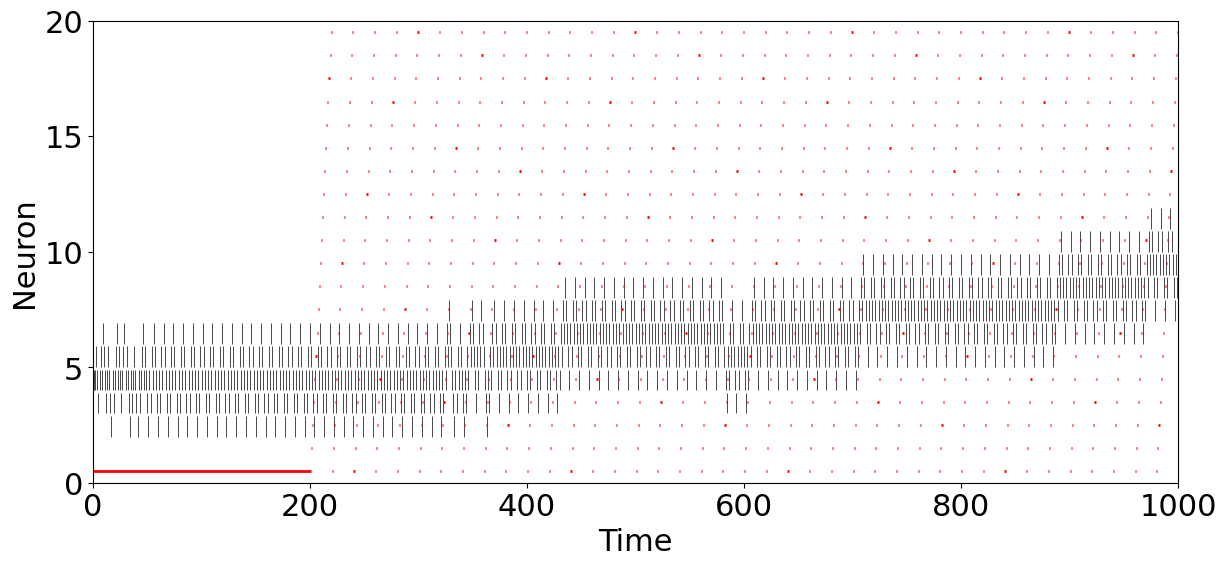

Speed 1 with input 0.5


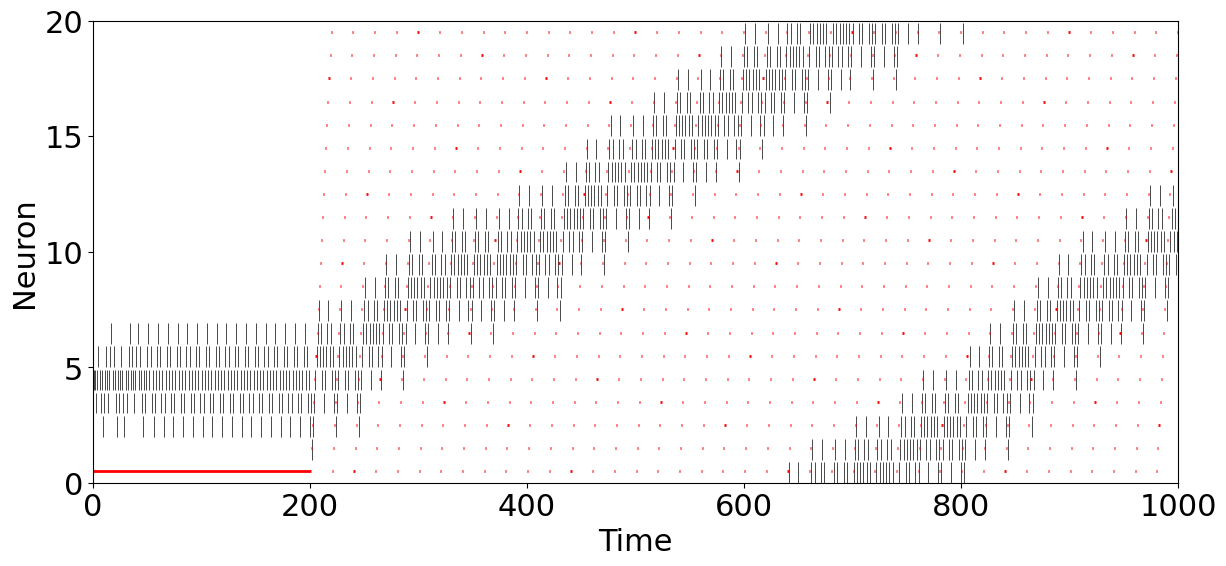

Speed 2 with input 0.3


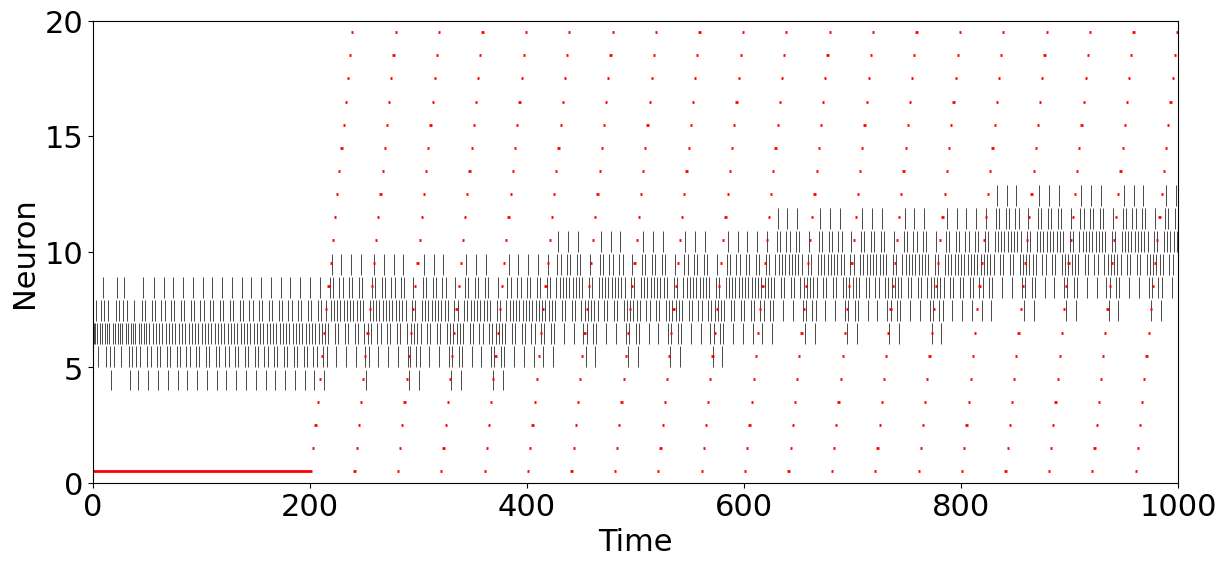

Speed 4 with input 0.12


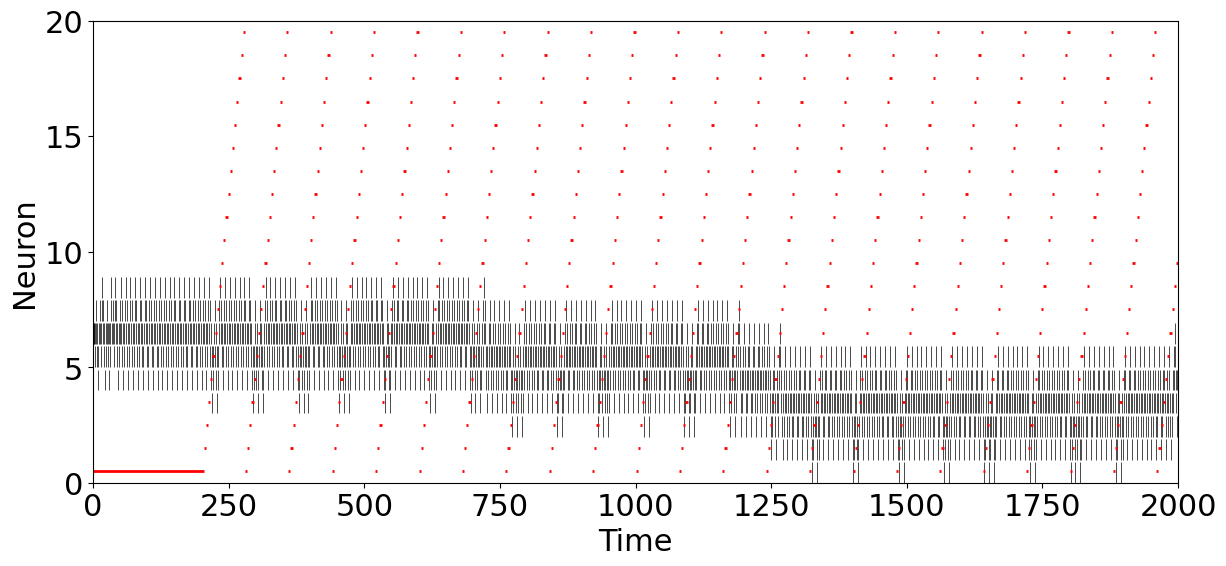

<Figure size 640x480 with 0 Axes>

In [ ]:
exps = [[1, 0.12], [1, 0.50], [2, 0.3], [4, 0.12]]

plt.figure(figsize=(12, 12))

for i, exp in enumerate(exps):
    print(f"Speed {exp[0]} with input {exp[1]}")
    if i < 3:
        spikes, _, cur_pos = rotating_action(1000, exp[0], exp[1])
    else:
        spikes, _, cur_pos = rotating_action(2000, exp[0], exp[1])
    plot_spike_tray(spikes, cur_pos)

plt.tight_layout()
plt.show()

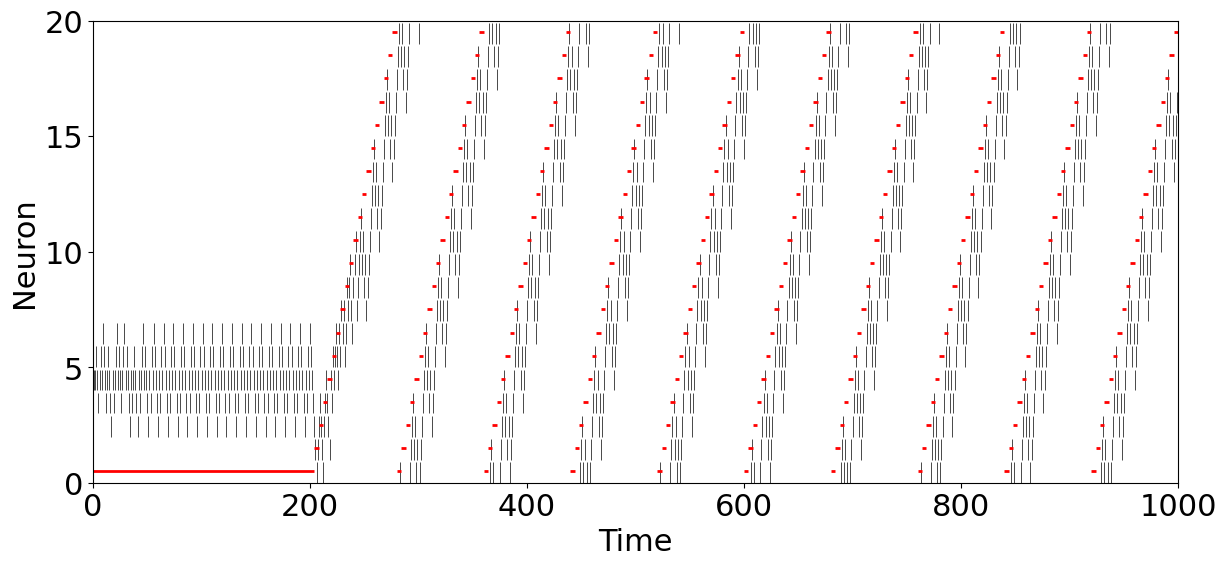

In [ ]:
plot_spike_tray(spikes[:, :1000], cur_pos[:,:1000])

Two behavioural differences.

If we have a fast rotating motion (1 position per timestep), we will need at least 0.36 approximately to have a revoluting activity which slowly rotates thourgh the atractor.

Lower activity than 0.36 will result in no movement on the bump. Increasing the activity will make the bump rotate faster, but it is not a continual increase, but sharp increases in the oscillation frecuency. When the input is too hight, the whole networks goes to a continual positive state.


We know it is rotating but not following the input rotation because one full revolution takes up to 1000 steps, while a spin for the input takes 20 steps.

If we have slower revolution time with low activity 0.12, it will end up moving in the oposite direction of the oscillation. Initially, the bump will try to move towards the direction of the cycle, but, when the cycle comes bback form the other part, it will start spiking there, sending negative voltage to the other section, when the oscilator reacehs the ending part of the bump, the negative activity will have make the bump unable to follow the oscilation, making it go towards the initial activity it sees. [Really bad explanation RN]

## Left-Right Controller + Goal PID


In [ ]:
class PIDController:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.integral = 0
        self.previous_error = 0

    def update(self, error):
        self.integral += error
        derivative = error - self.previous_error
        self.previous_error = error
        control_signal = self.kp * error + self.ki * self.integral + self.kd * derivative
        return control_signal

class ControllableRing:
    def __init__(self, N):
        self.N = N
        self.ring = RingAttractor(N, WTA=True)
        self.ring.init_local_connections([-0.4, -0.3, 0.6, 1, 0.6, -0.3, -0.4])

        self.left_ring = RingAttractor(N, WTA=True)
        self.left_ring.init_local_connections([-0.8, -0.6, -0.1, -0.05, -0.1, -0.6, -0.8])

        self.ring_to_left = 0.2 * np.identity(N)
        self.left_to_ring = np.zeros_like(self.ring_to_left)
        for j in range(20):
            self.left_to_ring[j][(j + 1) % 20] = 0.3
            self.left_to_ring[j][(j + 2) % 20] = 0.7
            self.left_to_ring[j][(j + 3) % 20] = 0.3

        self.right_ring = RingAttractor(N, WTA=True)
        self.right_ring.init_local_connections([-0.8, -0.6, -0.1, -0.05, -0.1, -0.6, -0.8])

        self.ring_to_right = 0.2 * np.identity(N)
        self.right_to_ring = np.zeros_like(self.ring_to_right)
        for j in range(20):
            self.right_to_ring[j][(j - 1 + 20) % 20] = 0.3
            self.right_to_ring[j][(j - 2 + 20) % 20] = 0.7
            self.right_to_ring[j][(j - 3 + 20) % 20] = 0.3

        self.goal_left = None
        self.goal_right = None
        self.pid_left = None
        self.pid_right = None

        self.control_signals_left = []
        self.control_signals_right = []

        self.control_errors_left = []
        self.control_errors_right = []

        self.cur_spikes = []

        self.bump_avg = np.zeros((N))

    def set_goals(self, goal):
        if goal < 0 or goal >= self.N:
            raise ValueError("Goal locations must be within the range [0, N-1].")
        self.goal = goal

    def set_pid_controllers(self, kp_left, ki_left, kd_left, kp_right, ki_right, kd_right):
        self.pid_left = PIDController(kp_left, ki_left, kd_left)
        self.pid_right = PIDController(kp_right, ki_right, kd_right)

    def step(self, input):
        # Calculate the current positions of the left and right rings
        left_current = self.left_to_ring @ self.left_ring.spikes
        right_current = self.right_to_ring @ self.right_ring.spikes

        # Call the step method of the main ring attractor with updated inputs
        self.ring.step(input + left_current + right_current)

        self.bump_avg *= 0.95
        self.bump_avg += 0.05 * self.ring.spikes


        # Calculate the errors between the current position and the goal positions for left and right rings
        if self.goal is not None:

            goal_temp = (self.goal - np.argmax(self.bump_avg) + self.ring.N) % self.N

            if goal_temp < 10:
                error_left = goal_temp
                error_right = 0
            else:
                error_right = 20 - goal_temp
                error_left = 0

            # Update the PID controllers and get the control signals for left and right rings
            control_signal_left = self.pid_left.update(error_left)/100
            control_signal_right = self.pid_right.update(error_right)/100


            if error_left > 0:
                control_signal_left = 0.0
                control_signal_right = error_left/50
            else:
                control_signal_left = error_right/50
                control_signal_right = 0.0

            self.control_errors_left.append(error_left)
            self.control_errors_right.append(error_right)

            self.control_signals_left.append(control_signal_left)
            self.control_signals_right.append(control_signal_right)

            self.cur_spikes.append(np.argmax(self.ring.spikes))

            # Apply the control signals to move the left and right rings towards their respective goals
            self.left_ring.step(self.ring_to_left @ self.ring.spikes + control_signal_left)
            self.right_ring.step(self.ring_to_right @ self.ring.spikes + control_signal_right)

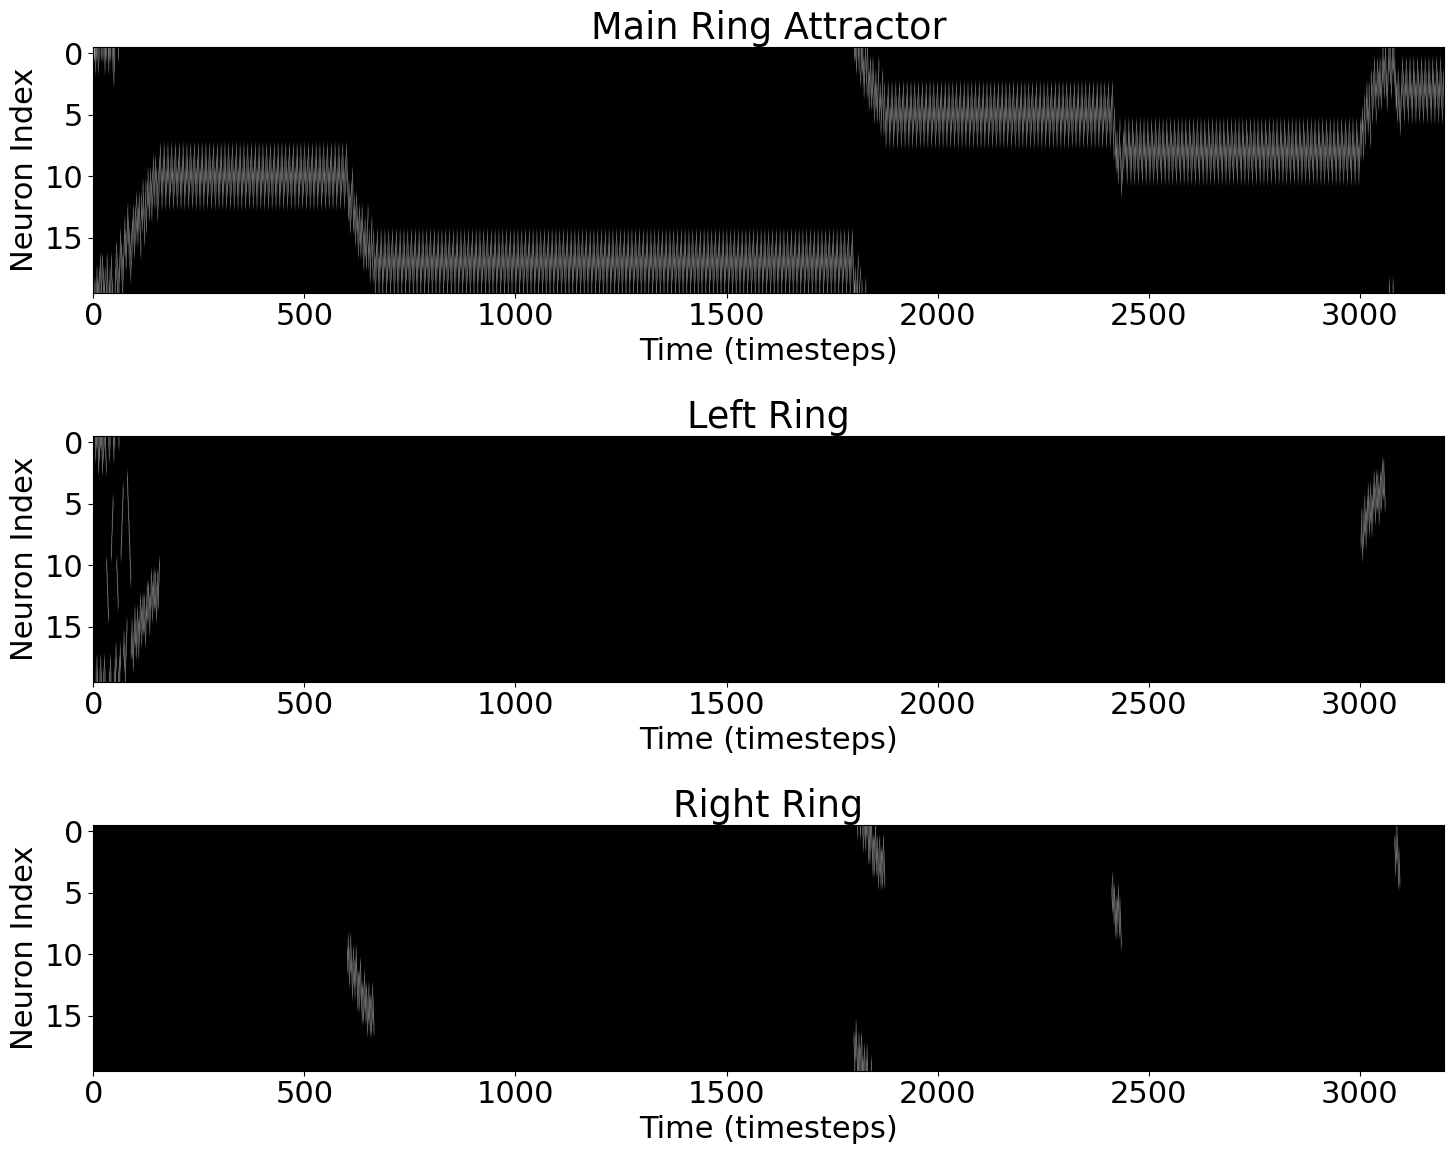

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# (Previous implementation of RingAttractor, PIDController, and ControllableRing classes)

# Create a ControllableRing model with 20 neurons
controllable_ring = ControllableRing(20)

# Set the goals for the left and right rings (e.g., goal at neuron index 5 for left ring and 15 for right ring)
controllable_ring.set_goals(goal = 3)

# Set PID controller parameters for the left and right rings
controllable_ring.set_pid_controllers(kp_left=0.1, ki_left=0.01, kd_left=0.01,
                                      kp_right=0.1, ki_right=0.01, kd_right=0.01)

# Create arrays to store spike activity of the main ring attractor and left/right rings
spikes_ring = np.zeros((20, 3200))
spikes_left_ring = np.zeros((20, 3200))
spikes_right_ring = np.zeros((20, 3200))

# Apply input to the main ring attractor (e.g., input to neuron index 0)
input_val = np.zeros(20)
input_val[0] = 0.5

# Run the simulation for 2000 steps
for t in range(3200):
    # Call the step method of the ControllableRing model with the input
    controllable_ring.step(input=input_val)

    if t == 50:
        input_val *= 0

    if t % 600 == 0:
        controllable_ring.set_goals(goal = np.random.randint(0,20))

    # Store the spike activity of the main ring attractor and left/right rings
    spikes_ring[:, t] = controllable_ring.ring.spikes
    spikes_left_ring[:, t] = controllable_ring.left_ring.spikes
    spikes_right_ring[:, t] = controllable_ring.right_ring.spikes

# Plot the spike activity of the main ring attractor and left/right rings
plt.figure(figsize=(15, 12))
plt.subplot(3, 1, 1)
plt.imshow(spikes_ring, cmap='gray', aspect='auto')
plt.title('Main Ring Attractor')
plt.xlabel('Time (timesteps)')
plt.ylabel('Neuron Index')

plt.subplot(3, 1, 2)
plt.imshow(spikes_left_ring, cmap='gray', aspect='auto')
plt.title('Left Ring')
plt.xlabel('Time (timesteps)')
plt.ylabel('Neuron Index')

plt.subplot(3, 1, 3)
plt.imshow(spikes_right_ring, cmap='gray', aspect='auto')
plt.title('Right Ring')
plt.xlabel('Time (timesteps)')
plt.ylabel('Neuron Index')

plt.tight_layout()
plt.show()



In [ ]:
class PIDController:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.integral = 0
        self.previous_error = 0

    def update(self, error):
        self.integral += error
        derivative = error - self.previous_error
        self.previous_error = error
        control_signal = self.kp * error + self.ki * self.integral + self.kd * derivative
        return control_signal

class ControllableRing:
    def __init__(self, N):
        self.N = N
        self.ring = RingAttractor(N, WTA=True)
        self.ring.init_local_connections([-0.4, -0.3, 0.6, 1, 0.6, -0.3, -0.4])

        self.left_ring = RingAttractor(N, WTA=True)
        self.left_ring.init_local_connections([-0.8, -0.6, -0.1, -0.05, -0.1, -0.6, -0.8])

        self.ring_to_left = 0.2 * np.identity(N)
        self.left_to_ring = np.zeros_like(self.ring_to_left)
        for j in range(20):
            self.left_to_ring[j][(j + 1) % 20] = 0.3
            self.left_to_ring[j][(j + 2) % 20] = 0.7
            self.left_to_ring[j][(j + 3) % 20] = 0.3

        self.right_ring = RingAttractor(N, WTA=True)
        self.right_ring.init_local_connections([-0.8, -0.6, -0.1, -0.05, -0.1, -0.6, -0.8])

        self.ring_to_right = 0.2 * np.identity(N)
        self.right_to_ring = np.zeros_like(self.ring_to_right)
        for j in range(20):
            self.right_to_ring[j][(j - 1 + 20) % 20] = 0.3
            self.right_to_ring[j][(j - 2 + 20) % 20] = 0.7
            self.right_to_ring[j][(j - 3 + 20) % 20] = 0.3

        self.goal_left = None
        self.goal_right = None
        self.pid_left = None
        self.pid_right = None

        self.control_signals_left = []
        self.control_signals_right = []

        self.control_errors_left = []
        self.control_errors_right = []

        self.cur_spikes = []

        self.bump_avg = np.zeros((N))

    def set_goals(self, goal):
        if goal < 0 or goal >= self.N:
            raise ValueError("Goal locations must be within the range [0, N-1].")
        self.goal = goal

    def set_pid_controllers(self, kp_left, ki_left, kd_left, kp_right, ki_right, kd_right):
        self.pid_left = PIDController(kp_left, ki_left, kd_left)
        self.pid_right = PIDController(kp_right, ki_right, kd_right)

    def step(self, input):
        # Calculate the current positions of the left and right rings
        left_current = self.left_to_ring @ self.left_ring.spikes
        right_current = self.right_to_ring @ self.right_ring.spikes

        # Call the step method of the main ring attractor with updated inputs
        self.ring.step(input + left_current + right_current)

        self.bump_avg *= 0.95
        self.bump_avg += 0.05 * self.ring.spikes


        # Calculate the errors between the current position and the goal positions for left and right rings
        if self.goal is not None:

            goal_temp = (self.goal - np.argmax(self.bump_avg) + self.ring.N) % self.N

            if goal_temp < 10:
                error_left = -np.sqrt(goal_temp)
                error_right = np.sqrt(goal_temp)
            else:
                error_right = -np.sqrt(20 - goal_temp)
                error_left = np.sqrt(20 - goal_temp)

            # Update the PID controllers and get the control signals for left and right rings
            control_signal_left = self.pid_left.update(error_left/20)
            control_signal_right = self.pid_right.update(error_right/20)

            self.control_errors_left.append(error_left/50)
            self.control_errors_right.append(error_right/50)

            self.control_signals_left.append(control_signal_left)
            self.control_signals_right.append(control_signal_right)

            self.cur_spikes.append(np.argmax(self.ring.spikes))

            # Apply the control signals to move the left and right rings towards their respective goals
            self.left_ring.step(self.ring_to_left @ self.ring.spikes + control_signal_left)
            self.right_ring.step(self.ring_to_right @ self.ring.spikes + control_signal_right)

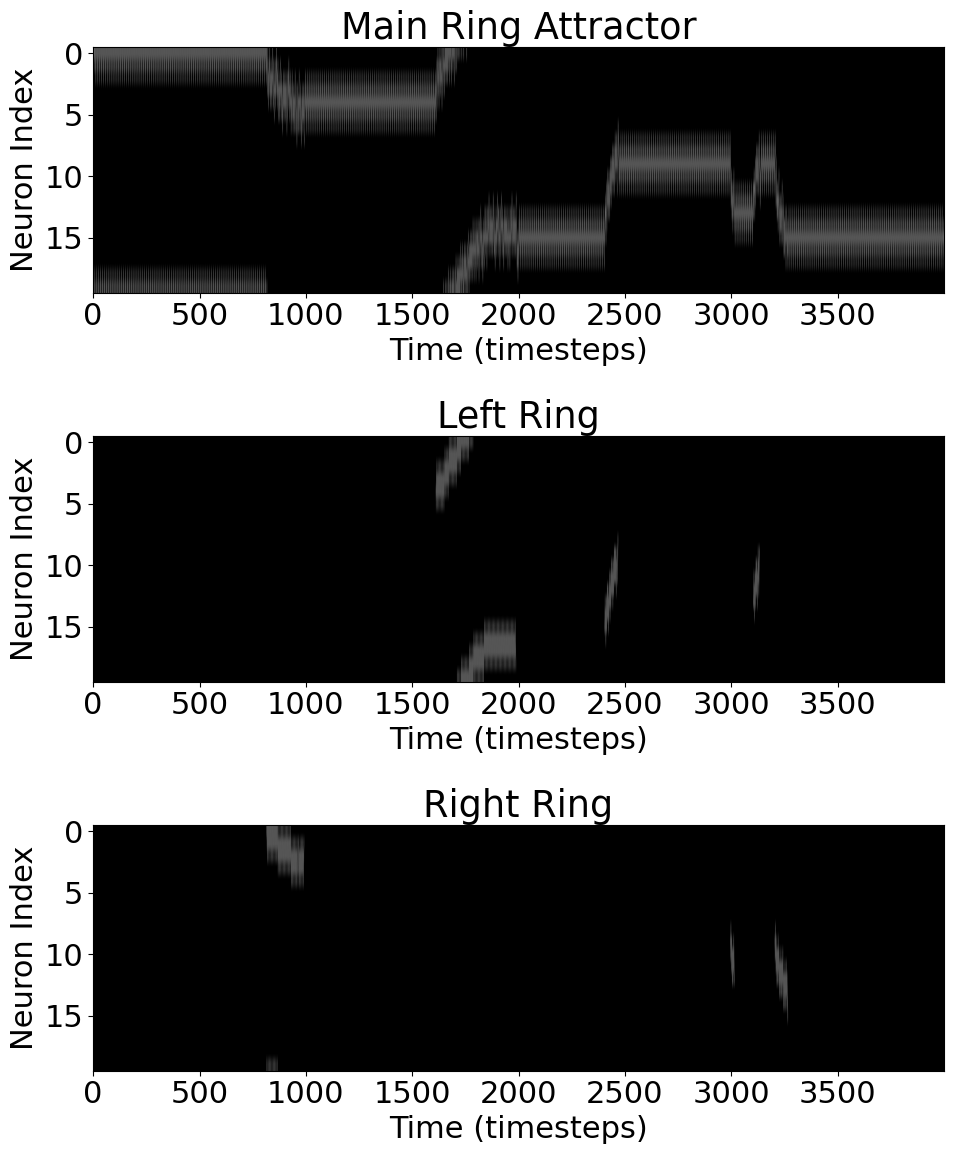

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# (Previous implementation of RingAttractor, PIDController, and ControllableRing classes)

# Create a ControllableRing model with 20 neurons
controllable_ring = ControllableRing(20)

# Set the goals for the left and right rings (e.g., goal at neuron index 5 for left ring and 15 for right ring)
controllable_ring.set_goals(goal = 13)

# Set PID controller parameters for the left and right rings
controllable_ring.set_pid_controllers(kp_left=0.34, ki_left=0.001, kd_left=0.1,
                                      kp_right=0.34, ki_right=0.001, kd_right=0.1)

# Create arrays to store spike activity of the main ring attractor and left/right rings
spikes_ring = np.zeros((20, 4000))
spikes_left_ring = np.zeros((20, 4000))
spikes_right_ring = np.zeros((20, 4000))

# Apply input to the main ring attractor (e.g., input to neuron index 0)
input_val = np.zeros(20)
input_val[0] = 0.5

# Run the simulation for 2000 steps
for t in range(4000):
    # Call the step method of the ControllableRing model with the input
    controllable_ring.step(input=input_val)

    if t == 50:
        input_val *= 0

    if t % 800 == 0:
        controllable_ring.set_goals(goal = np.random.randint(0,20))

    # Store the spike activity of the main ring attractor and left/right rings
    spikes_ring[:, t] = controllable_ring.ring.spikes
    spikes_left_ring[:, t] = controllable_ring.left_ring.spikes
    spikes_right_ring[:, t] = controllable_ring.right_ring.spikes

# Plot the spike activity of the main ring attractor and left/right rings
plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
plt.imshow(spikes_ring, cmap='gray', aspect='auto')
plt.title('Main Ring Attractor')
plt.xlabel('Time (timesteps)')
plt.ylabel('Neuron Index')

plt.subplot(3, 1, 2)
plt.imshow(spikes_left_ring, cmap='gray', aspect='auto')
plt.title('Left Ring')
plt.xlabel('Time (timesteps)')
plt.ylabel('Neuron Index')

plt.subplot(3, 1, 3)
plt.imshow(spikes_right_ring, cmap='gray', aspect='auto')
plt.title('Right Ring')
plt.xlabel('Time (timesteps)')
plt.ylabel('Neuron Index')

plt.tight_layout()
plt.show()


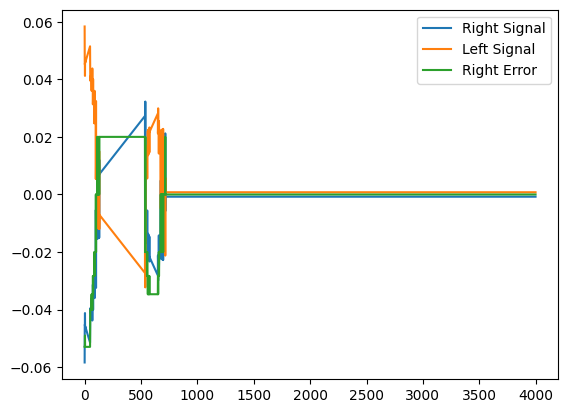

In [ ]:
plt.plot(controllable_ring.control_signals_right, label= "Right Signal")
plt.plot(controllable_ring.control_signals_left, label= "Left Signal")
plt.plot(controllable_ring.control_errors_right, label= "Right Error")
plt.legend()
plt.show()